<a href="https://colab.research.google.com/github/hws1302/partII-computing-exercises/blob/main/exercise3a_hs723_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3A: Helmhotlz Coils 

Write a program to calculate the B field caused by Helmholtz coils using:

$$\vec{B} = \frac{\mu_0}{4\pi}\frac{I\vec{dl} \wedge \vec{r}}{r^3}$$


And compare to analytical result:

$$ B = \frac{\mu_0IR^2}{2(R^2+x^2)^{3/2}}$$

In [18]:
import numpy as np
import matplotlib.pyplot as plt 

## Core Task 1 

For one coil find the field in the $(x,y)$ plane and see how this compares to the analytical result when $z=y=0$.

First we must come up with a way of integrating over some generalised shape.

In [19]:
def param_equation_to_points(func, param_range, n_points, centre_x, centre_y, centre_z):
    """
    x, y, z are the respecitve components of the parameterised equation
    param_range is the range that the parameter varies in 
    n_points is the number of points that we want
    *args are any arguments for the equation e.g. R for radius

    returns a list of the x, y, z components
    """

    params = np.linspace(param_range[0], param_range[1], n_points)[:-1]

    points = np.empty((n_points-1,3))

    for i, param in enumerate(params):

      points[i] = func(param)

    points = points + [centre_x, centre_y, centre_z]

    dls = points - np.roll(points, 3)

    return points, dls

We can write the parameterised equation for a circle in the $yz$-plane using an anonymous function `circle`

In [20]:
circle = lambda theta: [0,np.cos(theta),np.sin(theta)]

Next we write up the Biot-Savart in a function - it discards points that are too close to the coil as this would lead to arbitrarily big fields 

In [21]:
def dB(dl, r):
    '''
    Find contribution of a single segments to B field at a point by Biot-Savart

            Parameters:
                    dl (np.array): vector of current element
                    r (np.array): vector of test point to current element
                  

            Returns:
                    B_vector (np.array): [B_x, B_y, B_z] of magnetic field
    '''

    # here we check that the distance isn't too small so dB is arbitrarily large
    if min(np.sum(r**2, axis=1)) < 0.05:
      return np.zeros((99,3)) 

    else:
      return np.cross(dl, r) / (4 * np.pi * np.linalg.norm(r, axis=1).reshape(-1,1)**3)

We then write a function which sums up all the Biot-Savart contributions for all the current elements

In [22]:
def field_at_point(X, Y, Z, points, dls):
    '''
    Find B field vector at a point given the segment points and dl vetors 

            Parameters:
                    X (float): X-value of position 
                    Y (float): Y-value of position 
                    Z (float): Z-value of position 
                    points (np.array): list of points joining the current elements
                    dls (np.array): list of vectors of current elements
                  

            Returns:
                    B_vector (np.array): [B_x, B_y, B_z] of magnetic field
    '''

    rs = - points + np.array([X,Y,Z])

    B_vector = np.sum(dB(dls, rs), axis = 0)
    
    return B_vector

Here we can define the on-axis analytic solution (i.e. $z=y=0$). This is the second equation listed above.

Using $I = \frac{1}{\mu_0}$ and $R=1$ throughout the experiment this simplifies to the expression below.

In [23]:
analytic_solution = lambda x: 0.5 * (1 + x**2)**-1.5

In [24]:
def field_on_axis(n_segments, x_range):
    """
    Returns value of magnetic field on-axis (z=y=0) over some given x-range

            Parameters:
                    n_segments (int): number of segments in the wire 
                    x_range (np.array): list of x-values to evaluate at 
                  

            Returns:
                    B_x (np.array): list of values of the x-component of magnetic field
    """
    points, dls = param_equation_to_points(circle, (0, 2 * np.pi,), n_segments, 0, 0, 0)    


    B_x = np.zeros(len(x_range))

    for i, x in enumerate(x_range):

        n = field_at_point(x, 0, 0, points, dls)

        B_x[i] =  n[0]

    return B_x

Now plotting the numerical solution (Biot-Savart) against the analytical one.

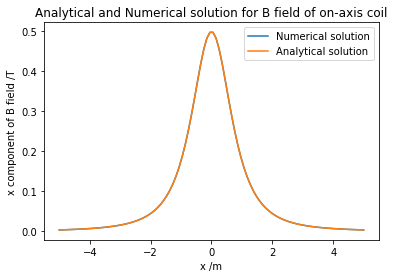

In [25]:
x_range = np.linspace(-5,5,100)
n_segments = 100

B_x = field_on_axis(n_segments, x_range)
plt.plot(x_range, B_x, label='Numerical solution')
plt.plot(x_range, analytic_solution(x_range), label='Analytical solution')

plt.legend()
plt.title('Analytical and Numerical solution for B field of on-axis coil')
plt.ylabel('x component of B field /T')
plt.xlabel('x /m')
plt.show()

We see that even for 100 segments the numerical method is indistinguishable from the analytic solution

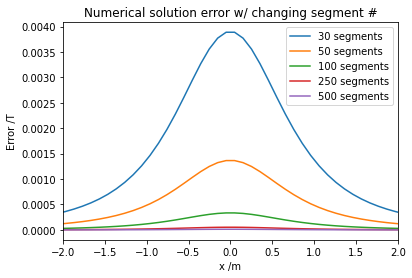

In [26]:
# need to figure out why the error is larger than expected, sure it is something to do with the way the points are done

x_range = np.linspace(-5,5,100)
n_segments_range = [30, 50, 100, 250, 500]

for n_segments in n_segments_range:

    analytic = analytic_solution(x_range)

    error = analytic - field_on_axis(n_segments, x_range)

    plt.plot(x_range, error, label = f'{n_segments} segments')

plt.legend()
plt.title('Numerical solution error w/ changing segment #')
plt.xlabel('x /m')
plt.ylabel('Error /T')

plt.xlim(-2,2)
plt.show()

As we add more wire segments the error reduces as we would expect

In [27]:
def B_field(n_coils, x_values, y_values, coil_range = 1, plot_coils = True): 
  """
    Returns values of x and y components for B field over a meshgrid

            Parameters:
                    n_coils (int): number of coils of current-carrying wire 
                    x_values (np.array): list of x-values to evaluate at 
                    y_values (np.array): list of y-values to evaluate at 
                    coil_range (int): distance between first and last coils
                    plot_coils (boolean): do you want to plot the points representing the coils
                  

            Returns:
                    B_x (np.array): x-components of B field in meshgrid shape
                    B_y (np.array): y-components of B field in meshgrid shape
    """

  values = []
  X, Y = np.meshgrid(x_values, y_values)
  
  centre_xs = np.linspace(-coil_range/2, coil_range/2, n_coils)

  for centre_x in centre_xs:

    points, dls = param_equation_to_points(circle, (0, 2 * np.pi,), 100, centre_x, 0, 0)

    if plot_coils: # here we plot the points representing the coil for easier visualisation
        plt.scatter(centre_x, 1, c='b', s=100)
        plt.scatter(centre_x, -1, c='b', s=100)

    for y in y_values:

      for x in x_values:

        values.append(field_at_point(x,y,0, points, dls))

  values = np.array(values)
  values = np.sum(np.split(values, len(centre_xs)), axis=0)

  size_x = len(x_values)
  size_y = len(y_values)

  return values[:,0].reshape(size_x,size_y), values[:,1].reshape(size_x,size_y)

In [28]:
def plot_B_field(n_coils: int, x_values, y_values, coil_range = 1, plot_coils = True, scale = 10):
  """
    Plots vector field using `B_field` function

            Parameters:
                    n_coils (int): number of coils of current-carrying wire 
                    x_values (np.array): list of x-values to evaluate at 
                    y_values (np.array): list of y-values to evaluate at 
                    coil_range (int): distance between first and last coils
                    plot_coils (boolean): do you want to plot the points representing the coils
                    scale (int): size of the arrows larger scale means smaller arrows
                  

            Returns:
                    plot: returns vectors field using `plt.quiver` method 
    """

  U, V = B_field(n_coils, x_values, y_values, coil_range, plot_coils)
  X, Y = np.meshgrid(x_values, y_values)
  size_x = len(x_values)
  size_y = len(y_values)

  plt.quiver(X, Y, U, V, scale=scale, color='g')
  plt.show()

Now we can use the `plot_B_field` function to visualise a single coil.

The blue points represent the $(x,y)$ coordinates of when the coil passes through $z=0$. The green lines are magnitude and direction of the $(x,y)$ components of the B field.

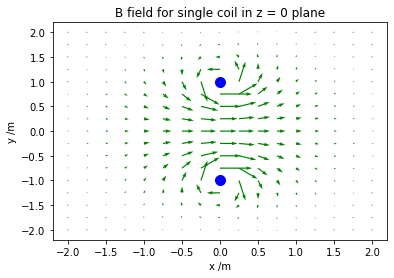

In [29]:
n_coils = 1
x_values = np.arange(-2, 2.25, 0.25)
y_values = np.arange(-2,2.25,0.25)
plt.title('B field for single coil in z = 0 plane')
plt.xlabel('x /m')
plt.ylabel('y /m')
plot_B_field(n_coils, x_values, y_values, coil_range=0)

##Core task 1 conclusion 

As we have seen we can break up shapes into a series of current elements and find their B field using Biot-Savart law:

- There is good agreement even for a relatviely small number of segments
- We can get arbitrarily close to the analytic solution by increasing the number of segments

##Core task 2 

Now plot for Helmholtz field (i.e. 2 coils)

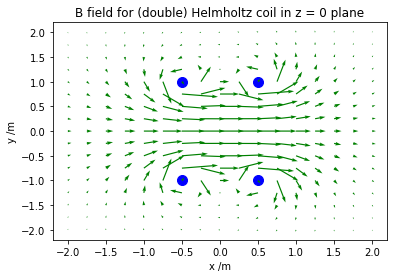

In [30]:
n_coils = 2
coil_range = 1
x_values = np.arange(-2, 2.25, 0.25)
y_values = np.arange(-2,2.25,0.25)
plt.title('B field for (double) Helmholtz coil in z = 0 plane')
plt.xlabel('x /m')
plt.ylabel('y /m')
plot_B_field(n_coils, x_values, y_values, coil_range=1, scale=10)

Now lets look at how uniform the field is at the centre of the coil ($x=y=z=0$). We can do this by plotting the deviation from the B field at the origin in square in the $z = 0$ plane with side lengths $0.05$m.

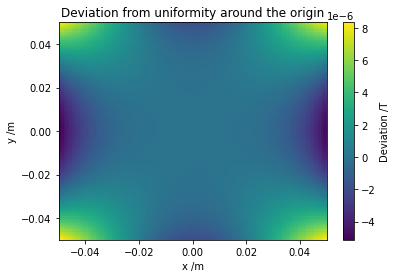

In [31]:
n_coils = 2
x_values = np.arange(-0.05, 0.051, 0.001)
y_values = np.arange(-0.05,0.051,0.001)
X, Y = np.meshgrid(x_values, y_values)
x, y = B_field(n_coils, x_values, y_values, plot_coils = False)

mag = np.sqrt(x**2 + y**2) 
mag -= mag[51][51] # remove the 

plt.title('Deviation from uniformity around the origin')
plt.xlabel('x /m')
plt.ylabel('y /m')
plt.xlim()

plt.pcolor(X, Y, mag)
plt.colorbar(label='Deviation /T')
plt.show()


In [32]:
1/np.max(mag) # max error

119768.60690547303

The maximum deviation ~ $1$ part in $10^5$ which is a pretty great approximation for uniform considering the simplicity of Helmholtz coil setup!

##Core task 2 conclusion

- The vector field for the Helmholtz coil is as expected and looks familiar
- Our model has shown that a Helmholtz coil setup is a very good approximation for a uniform field close to the origin


## Supplementary task 

What happens for $N$ coils whilst the spacing between the first and the last coil stays constant ($D = 10R$)

In [33]:
# set our parameters that don't change
coil_range = 10 
x_values = np.arange(-6, 6.25, 0.25)
y_values = np.arange(-2,2.25,0.25)

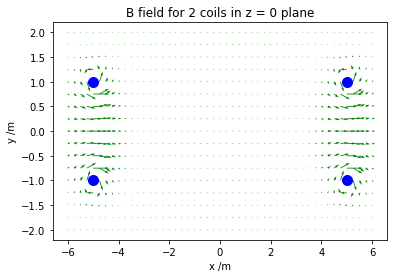

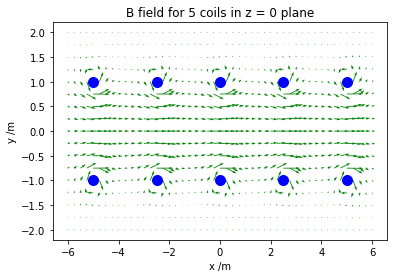

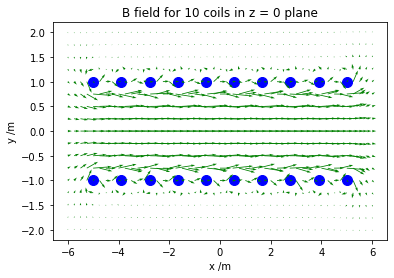

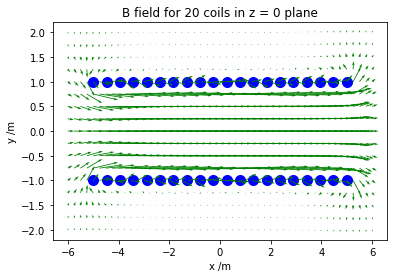

In [34]:
n_coils_list = [2,5,10,20]

for n_coils in n_coils_list:
  plt.title(f'B field for {n_coils} coils in z = 0 plane')
  plt.xlabel('x /m')
  plt.ylabel('y /m')
  plot_B_field(n_coils, x_values, y_values, coil_range=coil_range, scale=20)

##Supplmentary task conclusion 

We see that as the number of coils increases in the fixed distance the field becomes more uniform.

This explains why we see solenoids used so regularly to create a uniform magnetic field